# Setup

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys

sys.path.append("..")

from src.utils import read_yaml, read_tiff, save_yaml
from src.metrics import evaluate_metrics,evaluate_component_metrics

import os
from os.path import join

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup

from skimage.measure import label

import yaml
from scipy.ndimage import gaussian_filter
# sns.set_style("whitegrid")

In [7]:
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.labelleft'] = False

In [8]:
args = read_yaml("../args.yaml")

ROOT_PATH = "/home/luiz/multi-task-fcn/"

args["data_path"] = "/home/luiz/multi-task-fcn/11.0_version_data"

# Carregando de dados

- Leitura da imagem de satélite


In [9]:
# Load orthoimage with 3 bands
ORTHOIMAGE = np.moveaxis( read_tiff(args.ortho_image), 0, 2)[:, :, [5,3,2]]

- Leitura da ground truth segmentation

In [10]:
TRAIN_GT_MAP = read_tiff(args.train_segmentation_path)

TEST_GT_MAP = read_tiff(args.test_segmentation_path)

COMP_TEST_GT = label(TEST_GT_MAP)

- Leitura dos mapas de probabilidade e mapa de distâncias do modelo 

In [12]:
CURRENT_ITER_FOLDER = join(args.data_path, "iter_010")

depth_map = read_tiff(join(CURRENT_ITER_FOLDER, "raster_prediction/depth_itcFalse_1.1.TIF"))
pred_map = read_tiff(join(CURRENT_ITER_FOLDER, "raster_prediction/join_class_itcFalse_1.1.TIF"))
prob_map = read_tiff(join(CURRENT_ITER_FOLDER, "raster_prediction/join_prob_itcFalse_1.1.TIF"))

FileNotFoundError: File not found: /home/luiz/multi-task-fcn/15.0_version_data/iter_01/raster_prediction/depth_itcFalse_1.1.TIF

# Utils

In [ ]:
def add_mask(mask_ref, left, right, top, down):
    
    image = ORTHOIMAGE[top:down, left:right].copy()
    # image = image/image.max()
    image = (image - image.min()) / (np.quantile(image, 0.99) - image.min())

    # mask = np.where(comp_map[top:down, left:right] > 0, 1, 0)*0.3
    mask = mask_ref[top:down, left:right]

    image[:,:, 0] += mask * 0.7
    image[:,:, 1] += mask * 0.4
    image[:,:, 2] += mask * 0.4
    
    return image

In [ ]:
def square_comp_coords(comp_id, comp_map):
    coords = np.argwhere(comp_map == comp_id)

    down, top = coords[:, 0].max(),  coords[:, 0].min()

    right, left = coords[:, 1].max(),  coords[:, 1].min()

    # adding margin
    margin = 0.03

    # down += int(down*margin)
    # top -= int(top*margin)

    # right += int(right*margin)
    # left -= int(left*margin)
    dim = 256
    down += dim
    top -= dim

    right += dim
    left -= dim

    #### create a square ###
    if np.abs(top-down) > np.abs(right - left):
        right = left + np.abs(top-down)

    if np.abs(top-down) < np.abs(right - left):
        down = top + np.abs(right - left)
    
    return left, right, top, down


def extract_comp_squares(comp_id, comp_map, mask_ref):
    left, right, top, down = square_comp_coords(comp_id, comp_map,)

    image = ORTHOIMAGE[top:down, left:right].copy()
    # image = image/image.max()
    image = (image - image.min()) / (image.max() - image.min())

    # mask = np.where(comp_map[top:down, left:right] > 0, 1, 0)*0.3
    mask = mask_ref[top:down, left:right]

    image[:,:, 0] += mask * 0.7
    image[:,:, 1] += mask * 0.4
    image[:,:, 2] += mask * 0.4

    return image

# Testes de seleção de samples comparando com os dados de teste

In [ ]:
def add_mask(mask_ref, left, right, top, down):
    
    image = ORTHOIMAGE[top:down, left:right].copy()
    # image = image/image.max()
    image = (image - image.min()) / (np.quantile(image, 0.99) - image.min())

    # mask = np.where(comp_map[top:down, left:right] > 0, 1, 0)*0.3
    mask = mask_ref[top:down, left:right]

    image[:,:, 0] += mask * 0.6
    image[:,:, 1] += mask * 0.3
    image[:,:, 2] += mask * 0.6
    
    return image

## Usando conjunto de teste fixo

Selecionando algumas amostras aleatoriamente

In [ ]:
test_comp_ids = np.unique(COMP_TEST_GT)
test_comp_ids = test_comp_ids[np.nonzero(test_comp_ids)].copy()

np.random.seed(1)
# Componentes selecionados da base e teste
selected_comp_gt = np.random.choice(test_comp_ids, size = 10, replace = False)

np.unique(TEST_GT_MAP[np.isin(COMP_TEST_GT, selected_comp_gt)])

array([ 3,  4,  5,  7,  8,  9, 10, 12], dtype=uint8)

## Simulação de seleção de componentes

In [ ]:
def simulate(new_pred_map):
    np.random.seed(123)

    test_images = []
    predicted_images = []
    prob_images = []
    depth_images = []

    NUM_IMAGES = 5

    for j, comp_id in enumerate(selected_comp_gt):
        # coords = square_comp_coords(comp_id, all_labels_comp)
        coords = square_comp_coords(comp_id, COMP_TEST_GT)

        # raw_images.append(ORTHOIMAGE[coords[0] : coords[1], coords[2]:coords[3], :]/255)

        test_images.append( 
            add_mask(np.where(COMP_TEST_GT > 0, 1, 0)*0.5, *coords)
        )

        predicted_images.append(add_mask(np.where(new_pred_map > 0, 1, 0)*0.5, *coords))

        prob_images.append(add_mask(np.where(new_pred_map > 0, prob_map, 0)*0.7, *coords))

        depth_images.append(add_mask((np.where(new_pred_map > 0, depth_map+0.1, 0)), *coords))
        



    # for j in range(len(predicted_images)):
        fig, ax = plt.subplots(nrows=1, ncols = 4, sharex=False, sharey=False)

        fig.set_size_inches(12, 3)
        
        ax[0].imshow(test_images[j], interpolation='nearest')

        ax[1].imshow(predicted_images[j], interpolation='nearest')
        
        ax[2].imshow(prob_images[j], interpolation='nearest')

        ax[3].imshow(depth_images[j], interpolation='nearest')


        ax[0].set_title("Ground Truth test:", fontsize = 8)
        ax[1].set_title("Predicted:", fontsize = 8,)
        ax[2].set_title("Prob:", fontsize = 8)
        ax[3].set_title("Depth:", fontsize = 8)

        fig.tight_layout()

        plt.show()



# prob_gauss = gaussian_filter(prob_map, 1)
# depth_gauss = gaussian_filter(depth_map, 1)

# # new_pred_map = np.where((depth_gauss > 0.1) & (prob_gauss > 0.80), pred_map, 0)

# new_pred_map = np.where((depth_gauss > 0.15) & (prob_gauss > 0.9), pred_map, 0)

# # new_pred_map = np.where((depth_gauss + prob_gauss) > 1.3, pred_map, 0)

# simulate(new_pred_map)

In [ ]:
prob_gauss = gaussian_filter(prob_map, 1)
depth_gauss = gaussian_filter(depth_map, 1)

# new_pred_map = np.where(pred_map, 0)

new_pred_map = np.where( (depth_gauss > 0.2) & (prob_gauss > 0.95), pred_map, 0)

# new_pred_map = np.where( (prob_gauss+depth_gauss) > 1.2 , new_pred_map, 0)

simulate(new_pred_map)

KeyboardInterrupt: 

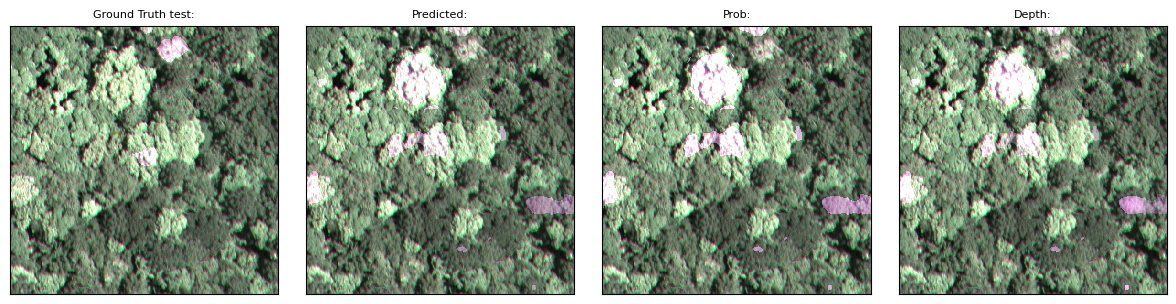

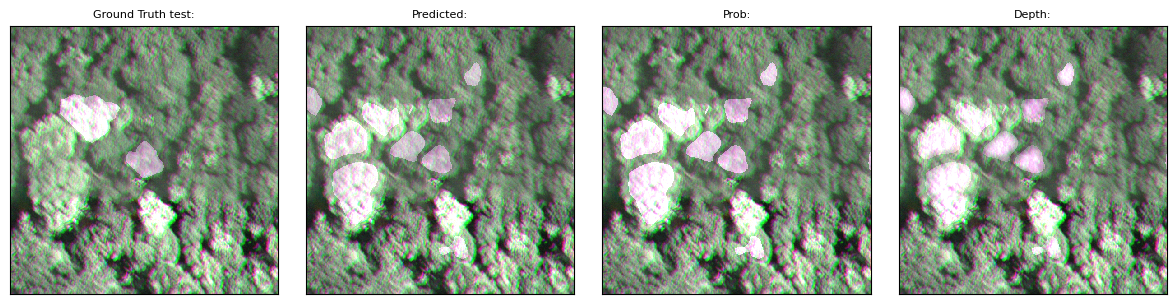

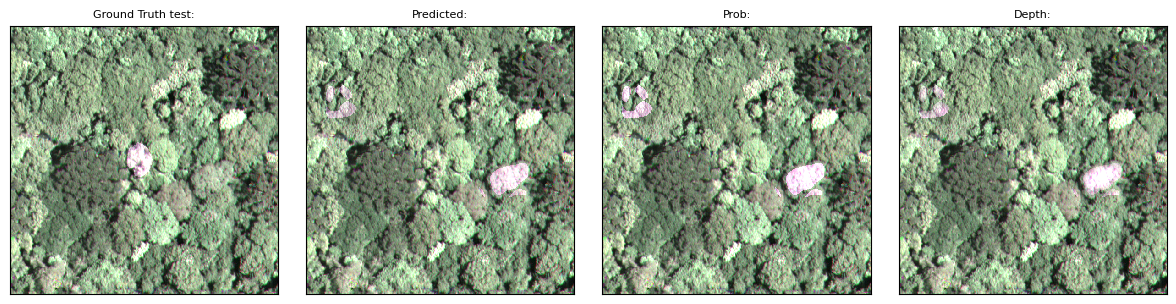

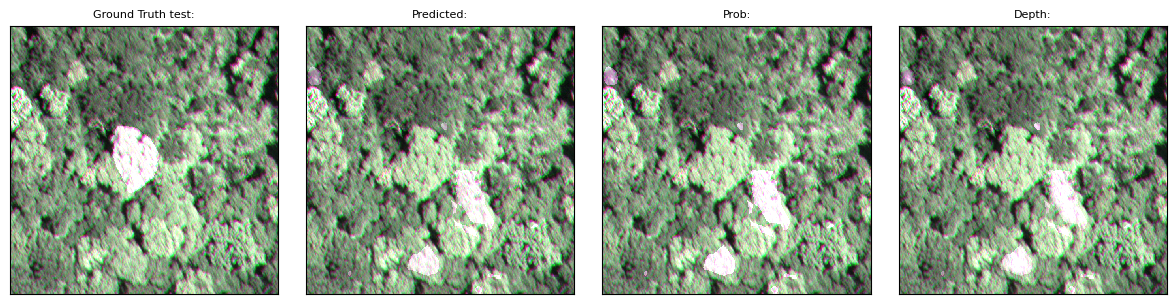

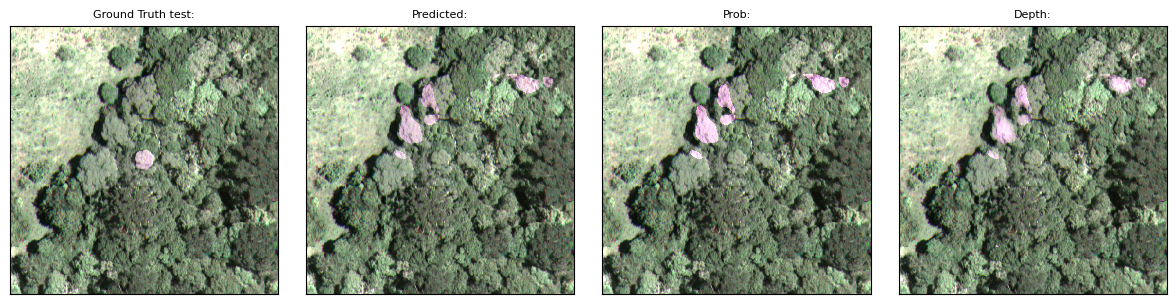

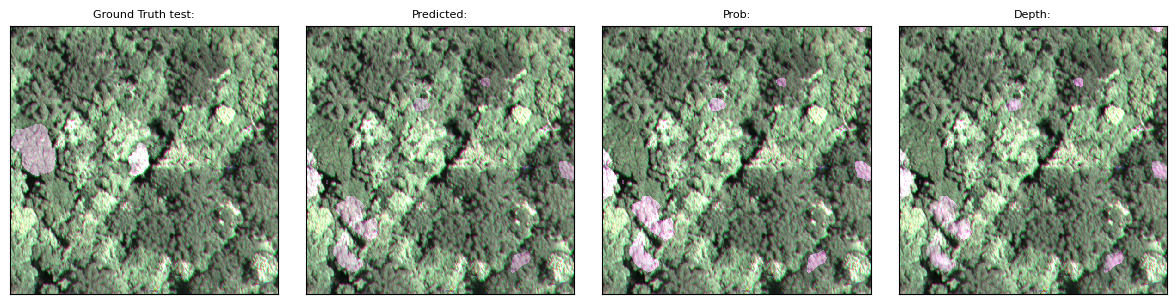

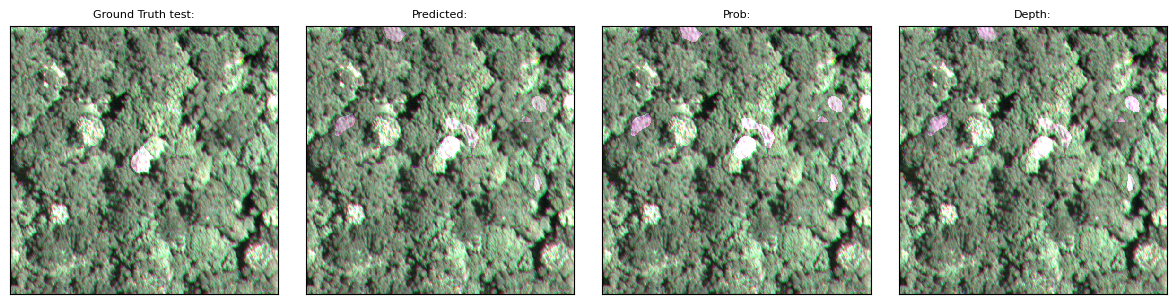

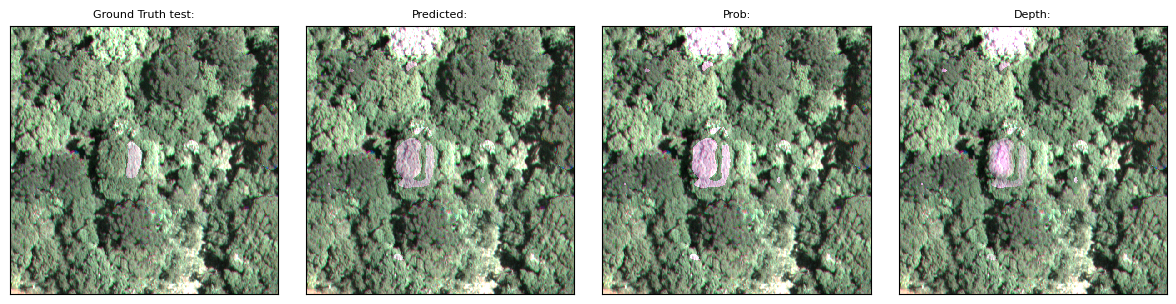

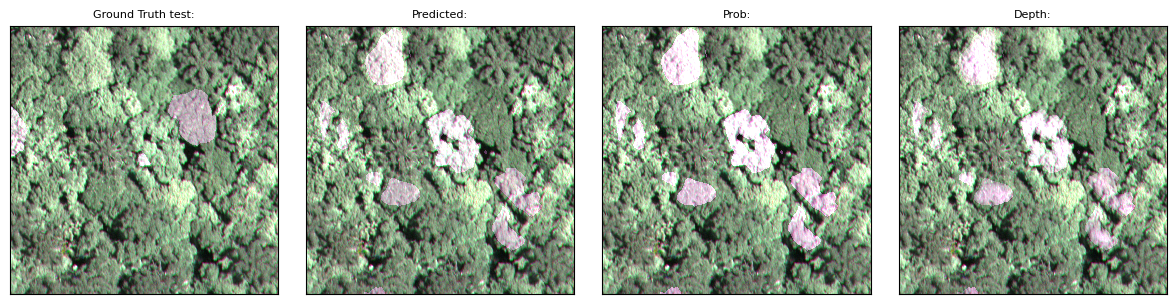

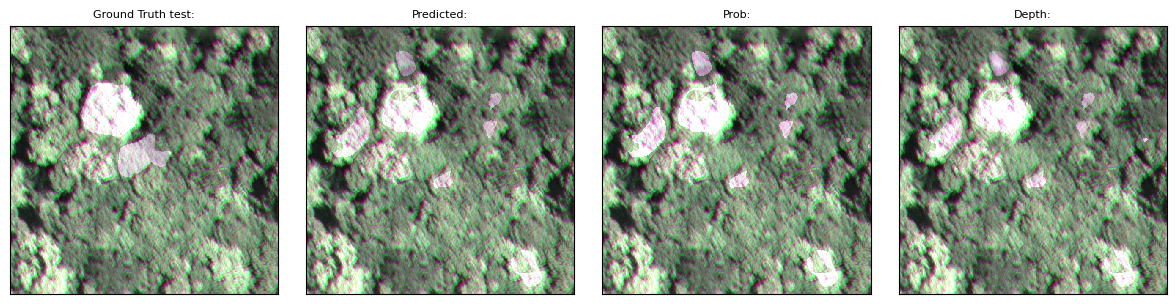

In [ ]:
prob_gauss = gaussian_filter(prob_map, 3)
depth_gauss = gaussian_filter(depth_map, 3)

# new_pred_map = np.where(pred_map, 0)

new_pred_map = np.where( (depth_gauss + prob_gauss > 1.2) & (prob_gauss > 0.95), pred_map, 0)

# new_pred_map = np.where( (prob_gauss+depth_gauss) > 1.2 , new_pred_map, 0)

simulate(new_pred_map)

# Busca bruta

Será que o fato do modelo 11.0, por estar prevendo os núcleos das copas, será que o modelo conseguiriam prever boas árvores se relaxarmos os parâmetros?

In [ ]:
# ORTHOIMAGE[]
center = ORTHOIMAGE.shape[0]//2, ORTHOIMAGE.shape[1]//2

NameError: name 'ORTHOIMAGE' is not defined

In [ ]:
dim = 1024
image_raw = ORTHOIMAGE[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim]
image_raw = (image_raw - image_raw.min())/(np.quantile(image_raw, 0.99) - image_raw.min())





image_raw_copy = image_raw.copy()        

new_pred_map = np.where( (depth_map + prob_map > 1.3), pred_map, 0)

mask = np.where(new_pred_map[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim] > 0, 1, 0)*0.3

mask_gt = np.where(TEST_GT_MAP[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim] > 0, 1, 0)

image_raw_copy[:,:, 0] += mask*0.3
image_raw_copy[:,:, 0] += mask*0.3
image_raw_copy[:,:, 0] += mask*0.5


# image_raw[:,:, 0] -= mask_gt*0.3
# image_raw[:,:, 0] -= mask_gt*0.3
# image_raw[:,:, 0] -= mask_gt*0.3

plt.figure(figsize= (15, 15))
plt.title(f"prob: {prob} - depth: {distance_map}")
plt.imshow(image_raw_copy)
plt.show()


NameError: name 'ORTHOIMAGE' is not defined

In [ ]:
dim = 1024
image_raw = ORTHOIMAGE[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim]
image_raw = (image_raw - image_raw.min())/(np.quantile(image_raw, 0.99) - image_raw.min())



for prob in [0.8, 0.85, 0.9, 0.95]:
    for distance_map in [0.05 , 0.1]:
        
        image_raw_copy = image_raw.copy()        

        new_pred_map = np.where( (depth_map > distance_map) & (prob_map > prob), pred_map, 0)
        
        mask = np.where(new_pred_map[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim] > 0, 1, 0)*0.3

        mask_gt = np.where(TEST_GT_MAP[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim] > 0, 1, 0)
        
        image_raw_copy[:,:, 0] += mask*0.3
        image_raw_copy[:,:, 0] += mask*0.3
        image_raw_copy[:,:, 0] += mask*0.5


        # image_raw[:,:, 0] -= mask_gt*0.3
        # image_raw[:,:, 0] -= mask_gt*0.3
        # image_raw[:,:, 0] -= mask_gt*0.3

        plt.figure(figsize= (15, 15))
        plt.title(f"prob: {prob} - depth: {distance_map}")
        plt.imshow(image_raw_copy)
        plt.show()

        
    
        

NameError: name 'ORTHOIMAGE' is not defined

In [ ]:
dim = 1024
image_raw = ORTHOIMAGE[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim]
image_raw = (image_raw - image_raw.min())/(np.quantile(image_raw, 0.99) - image_raw.min())



for prob in [0]:
    for distance_map in [0.05]:
        
        image_raw_copy = image_raw.copy()        

        new_pred_map = np.where( (depth_map > distance_map) & (prob_map > prob), pred_map, 0)
        
        mask = np.where(new_pred_map[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim] > 0, 
                        depth_map[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim], 
                        0)

        # mask_gt = np.where(TEST_GT_MAP[center[0] - dim : center[0] + dim, center[1] - dim : center[1] + dim] > 0, 1, 0)
        
        image_raw_copy[:,:, 0] += mask*0.3
        image_raw_copy[:,:, 0] += mask*0.3
        image_raw_copy[:,:, 0] += mask*0.5


        # image_raw[:,:, 0] -= mask_gt*0.3
        # image_raw[:,:, 0] -= mask_gt*0.3
        # image_raw[:,:, 0] -= mask_gt*0.3

        plt.figure(figsize= (15, 15))
        plt.title(f"prob: {prob} - depth: {distance_map}")
        plt.imshow(image_raw_copy)
        plt.show()

        
    
        

NameError: name 'ORTHOIMAGE' is not defined

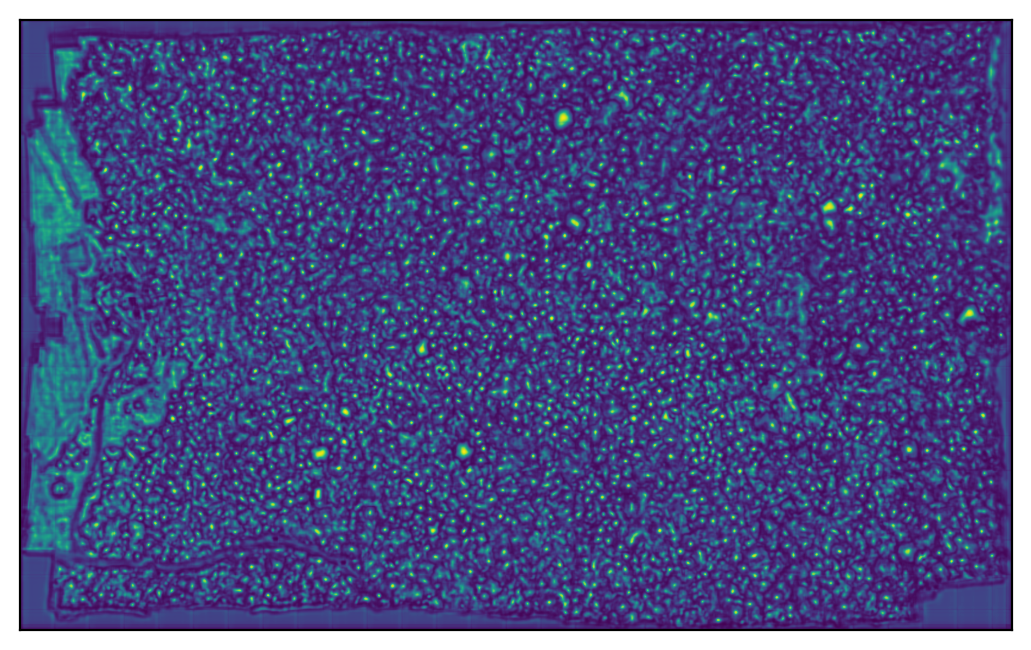

In [ ]:
plt.figure(dpi = 200)
plt.imshow(depth_map)
plt.show()